# Profile HMM of the HIV pol region

Authors
- Joshua Gilo
- Daphne Janelyn Go
- Kyle Carlo Lasala

### Download One Patient Sequence Data from the HIV Drug Resistance in Antiretroviral Treatment-Naïve Individuals in the Largest Public Hospital in Nicaragua by [1]

[1] Avila-Ríos, S., García-Morales, C., Matías-Florentino, M., Tapia-Trejo, D., Hernández-Álvarez, B. F., Moreira-López, S. E., Quant-Durán, C. J., Porras-Cortés, G., & Reyes-Terán, G. (2016). HIV Drug Resistance in Antiretroviral Treatment-Naïve Individuals in the Largest Public Hospital in Nicaragua, 2011-2015. PLoS ONE, 11(10), e0164156–e0164156. https://doi.org/10.1371/journal.pone.0164156

The dataset (SRA accession SRR4089886) consists of **paired-end sequencing data totaling 97,510 reads**. Taxonomic analysis showed 99.67% identified reads, primarily Human immunodeficiency virus type 1 (99.25%). 0.33% of reads were unclassified. For this analysis, only the forward read sequence data will be used.

In [ ]:
!prefetch SRR4089868 --output-directory .

In [ ]:
!fasterq-dump ./SRR4089868/SRR4089868.sra --split-files -O .

To get the RT protein sequence, the Human immunodeficiency virus type 1 (HXB2) reference genome was obtained through **[NCBI](https://www.ncbi.nlm.nih.gov/nuccore/K03455.1)**. The region from positions 2550 to 3870 of the reference genome was extracted as the subsequence corresponding to the RT protein.

### Download and metadata on gag-pol protein

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Bio import SearchIO
from Bio import SeqIO

We queried the UniProt Search API for the HIV gag-pol protein, restricting the results to entries in Swiss-Prot (`reviewed:true`). This search returned only the HIV-1 gag-pol entry. We then used the UniProt Stream API to download the complete protein record based on the accession number obtained from the search results.

In [2]:
base = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "gag-pol AND reviewed:true AND taxonomy_id:11676",  # taxo: 11676 is for HIV Type 1 (similar to the previous HO)
    "format": "tsv",
    "size": 100
}

In [3]:
try:
    response = requests.get(base, params=params)
    response.raise_for_status()
    metadata_tsv = response.text

    with open("gag_pol_prot.tsv", "w") as f:
        f.write(metadata_tsv)

    accessions = [
        line.split('\t')[0] # grabs first column which is the accession number
        for line in metadata_tsv.strip().split('\n')[1:] # skippu the header line
    ]

    if accessions:
        fasta_url = "https://rest.uniprot.org/uniprotkb/stream"
        fasta_params = {
            "format": "fasta",
            "query": " OR ".join([f"accession:{acc}" for acc in accessions])
        }
        fasta_response = requests.get(fasta_url, params=fasta_params)
        fasta_response.raise_for_status()
        with open("gag_pol_prot.fasta", "w") as f:
            f.write(fasta_response.text)

        print(f"Download complete: {len(accessions)} sequences saved.")
    else:
        print("No accession numbers found in metadata.")

except requests.exceptions.RequestException as e:
    print(f" An error occurred: {e}")


Download complete: 79 sequences saved.


#### EDA for HIV Subtypes for Retrieved HIV Type 1 Metadata

In [3]:
metadata_gag_pol = pd.read_csv("gag_pol_prot.tsv", sep="\t")
metadata_gag_pol.head()

,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P12498,POL_HV1J3,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,532
1,P05960,POL_HV1C4,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,550
2,P18802,POL_HV1ND,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1432
3,P03367,POL_HV1BR,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1447
4,O12158,POL_HV192,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1431


In [4]:
subtypes = metadata_gag_pol["Organism"].str.extract(r'\((.*?)\)')[0].unique()

In [5]:
metadata_gag_pol[['group', 'subtype', 'isolate']] = metadata_gag_pol['Organism'].str.extract(r"group ([A-Z])(?: subtype ([A-Z0-9]+))? \((?:isolate|strain) ([^)]+)\)")

In [6]:
metadata_gag_pol["subtype"] = metadata_gag_pol["subtype"].fillna("None")

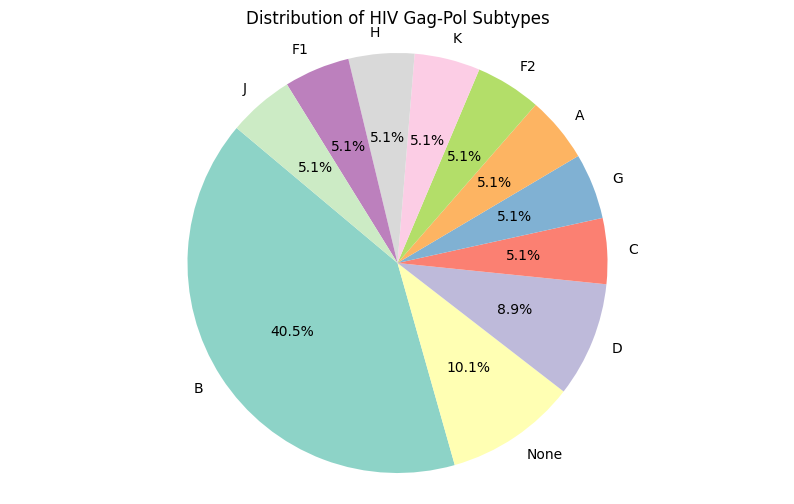

In [7]:
plt.figure(figsize=(10, 6))
plt.pie(metadata_gag_pol["subtype"].value_counts(), 
        labels=metadata_gag_pol["subtype"].value_counts().index, 
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("Set3", n_colors=len(metadata_gag_pol["subtype"].unique())))
plt.title("Distribution of HIV Gag-Pol Subtypes")
plt.axis('equal')
plt.show()

In [8]:
metadata_gag_pol.sort_values(by = ["subtype", "group"], inplace=True)

For each subtype, select two representative sequences. If a subtype is not defined (i.e., None), select two representatives from the HIV group instead. Use the sequences from the existing FASTA file, and save the selected representatives to a new FASTA file. This is done so that each subtype has an equal representation. **A total of 24 gag pol protein sequences were retrieved.**

In [12]:
selected_sequences = []
for subtype in metadata_gag_pol["subtype"].unique():
    subtype_sequences = metadata_gag_pol[metadata_gag_pol["subtype"] == subtype].head(2)
    selected_sequences.extend(subtype_sequences["Entry"].tolist())
    # if subtype is "None", just take the first 2 sequences from that group
    if subtype == "None":
        subtype_sequences = metadata_gag_pol[metadata_gag_pol["subtype"] == "None"]
        for group in subtype_sequences["group"].unique():
            group_sequences = subtype_sequences[subtype_sequences["group"] == group].head(2)
            selected_sequences.extend(group_sequences["Entry"].tolist())

# get the fasta sequences from the fasta file
fasta_sequences = []
with open("gag_pol_prot.fasta", "r") as f:
    write_sequence = False
    for line in f:
        if line.startswith(">"):
            if any(seq in line for seq in selected_sequences):
                write_sequence = True
                fasta_sequences.append(line.strip())
            else:
                write_sequence = False
        elif write_sequence:
            fasta_sequences[-1] += "\n" + line.strip()

with open("selected_gag_pol_prot.fasta", "w") as f:
    for seq in fasta_sequences:
        f.write(seq + "\n")

### Multiple Sequence Alignment

Take the 24 gag pol protein sequences in `selected_gag_pol_prot.fasta`, align them using MAFFT with an automatically chosen strategy (the L-INS-i strategy- accurate but very slow), and saves the aligned sequences to `gag_pol_aln.fasta`

In [14]:
!mafft --auto selected_gag_pol_prot.fasta > gag_pol_aln.fasta

### Building HMM

Train the HMM using the MSA alignment file

In [2]:
!hmmbuild -n gag_pol gag_pol.hmm gag_pol_aln.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b2 (February 2015); http://hmmer.org/
# Copyright (C) 2015 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             gag_pol_aln.fasta
# output HMM file:                  gag_pol.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     gag_pol_aln             24  1484  1434     0.47  0.590 

# CPU time: 0.55u 0.02s 00:00:00.57 Elapsed: 00:00:00.63


### Preprocessing HIV Patient FASTQ Data

Convert the `fastq` format to `fasta`

In [2]:
!seqtk seq -a SRR4089868_1.fastq > SRR4089868.fasta

Generate the 6 frames alignment of the amino acid sequence

In [4]:
!transeq -sequence SRR4089868.fasta -outseq SRR4089868_prot.fasta -frame 6

Translate nucleic acid sequences


Search protein sequences for gag-pol domains using HMMERSearch ran with its default parameters. The results will be filtered according to a defined threshold in a later step.

In [3]:
!hmmsearch --domtblout SRR4089868.domtblout -o SRR4089868.txt gag_pol.hmm SRR4089868_prot.fasta

### Aligned RT Prot Sequence to the HMM to see where the RT Region starts and ends

In [ ]:
!hmmsearch --domtblout RT.domtblout -o RT.txt gag_pol.hmm HXB2_RT.fasta

### Parsing

hmmsearch is in 1 indexing, seqio immediately corrects this to 0 indexing

In [13]:
def parse_domtblout(domtblout_file):
    data = []
    for query_result in SearchIO.parse(domtblout_file, 'hmmsearch3-domtab'):
        # print (query_result)
        for hit in query_result:
            for hsp in hit.hsps:
                data.append({
                    "query_id": query_result.id,
                    "hit_id": hit.id,
                    "evalue": hit.evalue,
                    "bitscore": hit.bitscore,
                    "description": hit.description, 
                    "bias": hit.bias,
                    "hmm_seq_length": hit.seq_len,
                    "best_doman_bias": hsp.bias,
                    "cevalue": hsp.evalue_cond,
                    "ievalue": hsp.evalue,
                    "best_domain_bitscore": hsp.bitscore,
                    "hit_strand": hsp.hit_strand,
                    "hit_start": hsp.hit_start,
                    "hit_end": hsp.hit_end,
                    "query_strand": hsp.query_strand,
                    "query_start": hsp.query_start,
                    "query_end": hsp.query_end
                })
    return data

### Inspect RT Alignment Results from HMMSearch to retrieve the RT Coordinates with respect to the pHMM

Inspect the alignment

In [14]:
RT_hits = parse_domtblout ("RT.domtblout")
rt_df = pd.DataFrame(RT_hits)
rt_df.head()

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end
0,gag_pol_aln,HXB2_RT,2.600000e-304,998.6,-,19.9,440,19.9,3.000000e-304,3.000000e-304,998.4,0,0,440,0,586,1026


Note that upon inspecting the alignment, the RT protein all aligned to a Match State of the pHMM for gag-pol protein. The start and end of RT are 586 and 1026 respectively.

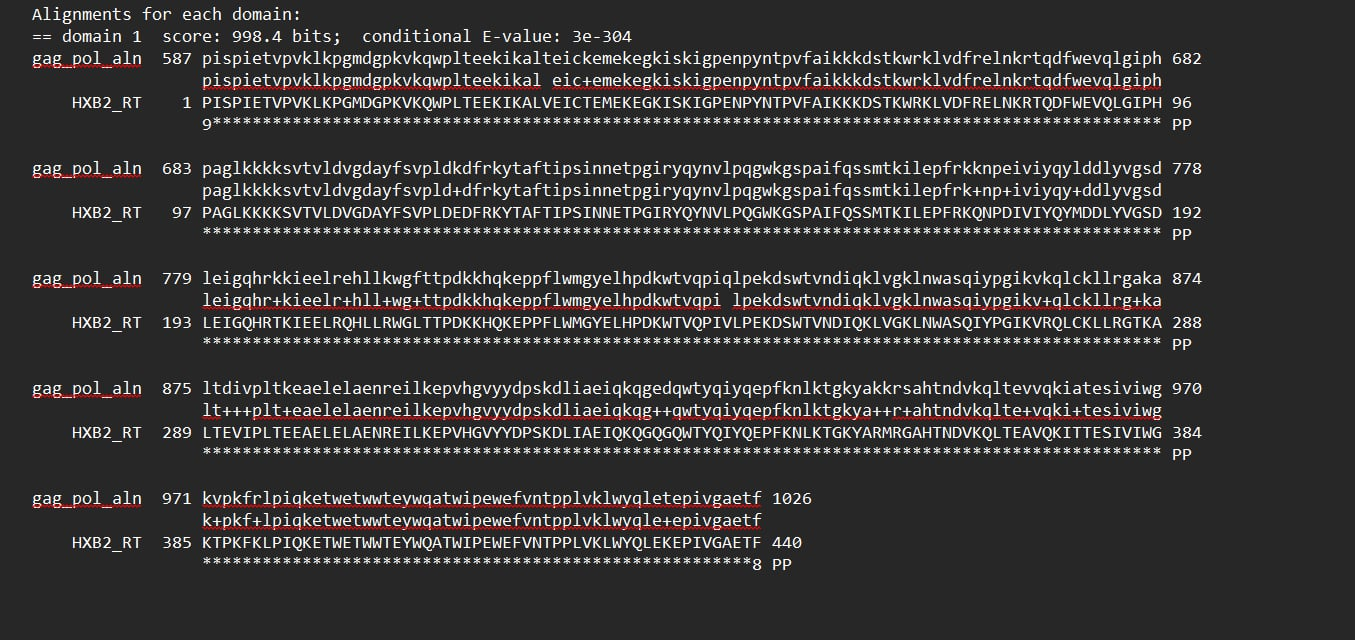

In [15]:
rt_start = 586 
rt_end = 1026

### Analysis of Six-Frame Translated Patient Sequence Alignments from HMMER hmmsearch Results

In [16]:
seq_hits = parse_domtblout("SRR4089868.domtblout")
seq_hits_df = pd.DataFrame(seq_hits)

Get rows with multiple hits but same `hit_id`. If there are multiple hits, take the one with the lowest evalue.

In [17]:
seq_best_hits_df = seq_hits_df.loc[seq_hits_df.groupby('hit_id')['ievalue'].idxmin()]
seq_best_hits_df = seq_best_hits_df.sort_values(by=['hit_id', 'ievalue'])
seq_best_hits_df = seq_best_hits_df.reset_index(drop=True)
seq_best_hits_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end
0,gag_pol_aln,SRR4089868.10000_5,1.600000e-18,70.7,10000 length=240,0.0,80,0.0,2.900000e-19,1.700000e-18,70.6,0,1,79,0,432,503
1,gag_pol_aln,SRR4089868.10001_6,1.600000e-48,170.1,10001 length=251,0.1,84,0.1,3.000000e-49,1.700000e-48,170.0,0,0,83,0,712,795
2,gag_pol_aln,SRR4089868.10002_2,8.500000e-52,181.0,10002 length=249,0.2,83,0.2,1.600000e-52,9.300000e-52,180.8,0,0,83,0,622,705
3,gag_pol_aln,SRR4089868.10003_6,2.500000e-43,152.9,10003 length=251,1.1,84,1.1,4.600000e-44,2.700000e-43,152.8,0,0,83,0,498,581
4,gag_pol_aln,SRR4089868.10004_4,4.700000e-32,115.6,10004 length=249,0.1,83,0.1,8.300000e-33,4.800000e-32,115.5,0,3,83,0,465,541
5,gag_pol_aln,SRR4089868.10005_6,1.500000e-49,173.5,10005 length=251,2.4,84,2.4,2.800000e-50,1.600000e-49,173.4,0,0,84,0,577,661
6,gag_pol_aln,SRR4089868.10006_4,7.300000e-45,158.0,10006 length=235,0.1,78,0.1,1.300000e-45,7.900000e-45,157.9,0,0,78,0,719,797
7,gag_pol_aln,SRR4089868.10007_4,3.400000e-51,179.0,10007 length=251,0.1,83,0.1,6.400000e-52,3.700000e-51,178.8,0,0,83,0,670,753
8,gag_pol_aln,SRR4089868.10008_3,2.000000e-37,133.4,10008 length=200,0.1,66,0.1,3.700000e-38,2.100000e-37,133.2,0,0,66,0,723,789
9,gag_pol_aln,SRR4089868.10009_6,1.400000e-47,167.0,10009 length=251,4.1,84,4.1,2.700000e-48,1.600000e-47,166.8,0,0,84,0,523,607


The format of `hid_id` is `<read_id>_<frame_id>`. So to get the `read_id`, we only consider the string before the character `_`.

In [18]:
seq_best_hits_df["read_id"] = seq_best_hits_df["hit_id"].str.split("_").str[0]

For each `read_id`, select the frame with the lowest e-value, noting that only one of the six possible frames is valid for any given read.

In [19]:
seq_best_read_df = seq_best_hits_df.loc[seq_best_hits_df.groupby('read_id')['ievalue'].idxmin()]
seq_best_read_df = seq_best_read_df.sort_values(by=['read_id', 'ievalue'])
seq_best_read_df = seq_best_read_df.reset_index(drop=True)
seq_best_read_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.1_2,1.900000e-17,67.1,1 length=149,0.1,50,0.1,3.500000e-18,2.100000e-17,67.0,0,0,49,0,745,794,SRR4089868.1
1,gag_pol_aln,SRR4089868.10_5,2.100000e-45,159.8,10 length=249,0.6,83,0.6,3.900000e-46,2.300000e-45,159.7,0,0,82,0,509,591,SRR4089868.10
2,gag_pol_aln,SRR4089868.100_2,9.100000e-19,71.5,100 length=242,0.0,81,0.0,1.700000e-19,1.000000e-18,71.3,0,6,80,0,432,502,SRR4089868.100
3,gag_pol_aln,SRR4089868.1000_6,6.400000e-32,115.1,1000 length=193,0.2,64,0.2,1.200000e-32,6.800000e-32,115.0,0,1,64,0,480,543,SRR4089868.1000
4,gag_pol_aln,SRR4089868.10000_5,1.600000e-18,70.7,10000 length=240,0.0,80,0.0,2.900000e-19,1.700000e-18,70.6,0,1,79,0,432,503,SRR4089868.10000
5,gag_pol_aln,SRR4089868.10001_6,1.600000e-48,170.1,10001 length=251,0.1,84,0.1,3.000000e-49,1.700000e-48,170.0,0,0,83,0,712,795,SRR4089868.10001
6,gag_pol_aln,SRR4089868.10002_2,8.500000e-52,181.0,10002 length=249,0.2,83,0.2,1.600000e-52,9.300000e-52,180.8,0,0,83,0,622,705,SRR4089868.10002
7,gag_pol_aln,SRR4089868.10003_6,2.500000e-43,152.9,10003 length=251,1.1,84,1.1,4.600000e-44,2.700000e-43,152.8,0,0,83,0,498,581,SRR4089868.10003
8,gag_pol_aln,SRR4089868.10004_4,4.700000e-32,115.6,10004 length=249,0.1,83,0.1,8.300000e-33,4.800000e-32,115.5,0,3,83,0,465,541,SRR4089868.10004
9,gag_pol_aln,SRR4089868.10005_6,1.500000e-49,173.5,10005 length=251,2.4,84,2.4,2.800000e-50,1.600000e-49,173.4,0,0,84,0,577,661,SRR4089868.10005


Retain only hits with an e-value less than $1e^{-5}$ to minimize false positive hits.

In [20]:
seq_best_hits_eval_df = seq_best_read_df[seq_best_read_df['ievalue'] < 1e-5]
seq_best_hits_eval_df = seq_best_hits_eval_df.sort_values(by=['query_id', 'ievalue'])
seq_best_hits_eval_df = seq_best_hits_eval_df.reset_index(drop=True)
seq_best_hits_eval_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.20881_2,2.400000e-53,186.1,20881 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.20881
1,gag_pol_aln,SRR4089868.23551_6,2.400000e-53,186.1,23551 length=251,0.1,84,0.1,4.500000e-54,2.600000e-53,186.0,0,0,84,0,658,742,SRR4089868.23551
2,gag_pol_aln,SRR4089868.24650_2,2.400000e-53,186.1,24650 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.24650
3,gag_pol_aln,SRR4089868.336_6,2.400000e-53,186.1,336 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.336
4,gag_pol_aln,SRR4089868.35612_6,2.400000e-53,186.1,35612 length=251,0.1,84,0.1,4.500000e-54,2.600000e-53,186.0,0,0,84,0,658,742,SRR4089868.35612
5,gag_pol_aln,SRR4089868.58922_2,2.400000e-53,186.1,58922 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.58922
6,gag_pol_aln,SRR4089868.68224_2,2.400000e-53,186.1,68224 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.68224
7,gag_pol_aln,SRR4089868.71648_6,2.400000e-53,186.1,71648 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.71648
8,gag_pol_aln,SRR4089868.76113_6,2.400000e-53,186.1,76113 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.76113
9,gag_pol_aln,SRR4089868.81140_2,2.400000e-53,186.1,81140 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.81140


We now want to retrive the sequence hits that are within the range of our identified RT coordinates. We did this for both without any filter and with filter of e-value $< 1e^-5$.

Get reads within the RT range from rt_start to rt_end and have hits with  e-value $< 1e^-5$

In [22]:
rt_hits = seq_best_hits_eval_df[(seq_best_hits_eval_df['query_start'] >= rt_start) & (seq_best_hits_eval_df['query_end'] <= rt_end)]
rt_hits = rt_hits.sort_values(by=['query_start', 'query_end', 'ievalue'])
rt_hits = rt_hits.reset_index(drop=True)
rt_hits.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.34232_3,1.000000e-19,74.7,34232 length=132,1.2,44,1.2,1.800000e-20,1.000000e-19,74.6,0,0,43,0,586,629,SRR4089868.34232
1,gag_pol_aln,SRR4089868.94004_5,4.100000e-24,89.2,94004 length=151,1.9,51,1.9,7.400000e-25,4.300000e-24,89.1,0,0,50,0,586,636,SRR4089868.94004
2,gag_pol_aln,SRR4089868.23138_3,4.500000e-39,138.8,23138 length=213,3.5,71,3.5,8.400000e-40,4.900000e-39,138.7,0,0,70,0,586,656,SRR4089868.23138
3,gag_pol_aln,SRR4089868.41239_5,8.300000e-43,151.2,41239 length=223,3.9,75,3.9,1.500000e-43,8.900000e-43,151.1,0,0,74,0,586,660,SRR4089868.41239
4,gag_pol_aln,SRR4089868.56064_4,4.200000e-48,168.7,56064 length=243,2.6,81,2.6,7.900000e-49,4.600000e-48,168.6,0,0,81,0,586,667,SRR4089868.56064
5,gag_pol_aln,SRR4089868.28393_6,2.900000e-44,156.0,28393 length=251,2.0,84,2.0,5.200000e-45,3.100000e-44,155.9,0,1,83,0,586,668,SRR4089868.28393
6,gag_pol_aln,SRR4089868.19601_5,8.600000e-50,174.3,19601 length=251,3.0,84,3.0,1.600000e-50,9.300000e-50,174.2,0,0,83,0,586,669,SRR4089868.19601
7,gag_pol_aln,SRR4089868.25462_1,1.100000e-49,173.9,25462 length=250,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.25462
8,gag_pol_aln,SRR4089868.2901_1,1.100000e-49,173.9,2901 length=250,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.2901
9,gag_pol_aln,SRR4089868.74430_5,1.100000e-49,173.9,74430 length=251,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.74430


Get reads within the RT range without any E-value threshold

In [36]:
rt_hits_2 = seq_best_hits_df[(seq_best_hits_df['query_start'] >= rt_start) & (seq_best_hits_df['query_end'] <= rt_end)]
rt_hits_2 = rt_hits_2.sort_values(by=['query_start', 'query_end', 'ievalue'])
rt_hits_2 = rt_hits_2.reset_index(drop=True)
rt_hits_2.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.34232_3,1.000000e-19,74.7,34232 length=132,1.2,44,1.2,1.800000e-20,1.000000e-19,74.6,0,0,43,0,586,629,SRR4089868.34232
1,gag_pol_aln,SRR4089868.94004_5,4.100000e-24,89.2,94004 length=151,1.9,51,1.9,7.400000e-25,4.300000e-24,89.1,0,0,50,0,586,636,SRR4089868.94004
2,gag_pol_aln,SRR4089868.23138_3,4.500000e-39,138.8,23138 length=213,3.5,71,3.5,8.400000e-40,4.900000e-39,138.7,0,0,70,0,586,656,SRR4089868.23138
3,gag_pol_aln,SRR4089868.41239_5,8.300000e-43,151.2,41239 length=223,3.9,75,3.9,1.500000e-43,8.900000e-43,151.1,0,0,74,0,586,660,SRR4089868.41239
4,gag_pol_aln,SRR4089868.56064_4,4.200000e-48,168.7,56064 length=243,2.6,81,2.6,7.900000e-49,4.600000e-48,168.6,0,0,81,0,586,667,SRR4089868.56064
5,gag_pol_aln,SRR4089868.28393_6,2.900000e-44,156.0,28393 length=251,2.0,84,2.0,5.200000e-45,3.100000e-44,155.9,0,1,83,0,586,668,SRR4089868.28393
6,gag_pol_aln,SRR4089868.19601_5,8.600000e-50,174.3,19601 length=251,3.0,84,3.0,1.600000e-50,9.300000e-50,174.2,0,0,83,0,586,669,SRR4089868.19601
7,gag_pol_aln,SRR4089868.25462_1,1.100000e-49,173.9,25462 length=250,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.25462
8,gag_pol_aln,SRR4089868.2901_1,1.100000e-49,173.9,2901 length=250,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.2901
9,gag_pol_aln,SRR4089868.74430_5,1.100000e-49,173.9,74430 length=251,3.1,84,3.1,2.100000e-50,1.200000e-49,173.8,0,0,83,0,586,669,SRR4089868.74430


Number of RT hits with e-value $<1e^-5$ 

In [23]:
rt_read_ids = rt_hits['hit_id'].unique()
print(f"Number of reads with RT hits: {len(rt_read_ids)}")

Number of reads with RT hits: 60598


Number of RT hits without e-value filter

In [37]:
rt_read_ids_2 = rt_hits_2['hit_id'].unique()
print(f"Number of reads with RT hits: {len(rt_read_ids_2)}")

Number of reads with RT hits: 62600


pHMM gives us an E-value to assess the significance of a certain hit. **There are 62,600 RT hits which is greater than the 61,103 of local alignment using LAST.** In the hope of reducing the number of false positives, we can only include those hits that have an **e-value of < 1e-5**. This results in a total of **60,598 RT hits**. We will use these filtered RT hits for the rest of the analysis.

Get the `hit_id`, access the coordinates from the `hit_start` and `hit_end`, then get the sequences from the FASTA file containing the six-frame translations of the patient sequence reads, and store only the subsequences defined by these coordinates.

In [24]:
def extract_sequences_from_fasta(fasta_file, read_ids):
    sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        if record.id in read_ids:
            sequences[record.id] = str(record.seq)
    for index, row in rt_hits.iterrows():
        hit_id = row['hit_id']
        if hit_id in sequences:
            start = row['hit_start']
            end = row['hit_end']
            sequences[hit_id] = sequences[hit_id][start:end]
    return sequences

In [26]:
rt_sequences = extract_sequences_from_fasta("SRR4089868_prot.fasta", rt_read_ids)

Save to csv file for faster loading

In [ ]:
with open("rt_sequences.csv", "w") as f:
    f.write("read_id, sequence\n")

Load the  csv file

In [27]:
rt_sequences_df = pd.read_csv('rt_sequences.csv')
rt_sequences_df.head()

,read_id,sequence
0,SRR4089868.1_2,FQSSMTKIL*PFRKGNPELVIYQYMDDLYVGSDLEIGQHRTKIEELRQH
1,SRR4089868.2_3,TIPIINNETPGIRYQYNFLPQGWKGSPAIFQSSMTKILEPFRKGNP...
2,SRR4089868.3_5,SQIYSGIKVRQLCKLLRGAKALTEVVTLTEEAELELAENREILKN
3,SRR4089868.4_2,NTPVFAIKKKDSTKWRKLVDFRELNKRTQEFWEVQLGIPHPAGLKK...
4,SRR4089868.5_6,IEELRQHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWTVQPVTLP...


###  Sites of interest relevant to NRTI resistance
As we aim to compare the pHMM analysis to the local sequence alignment done on the previous module, our analysis will focus on Zidovudine and Stavudine, specifically on key positions where mutations are associated with resistance to these drugs.




For Zidovudine, our analysis will focus on six key codon positions in the RT region: 41, 67, 70, 210, 215, and 219. In the HXB2 reference genome, the wild-type amino acids at these positions are L, N, R, W, Y, and Q, respectively. Mutations at these sites, such as M41L, D67N, K70R, L210W, T215Y/F, and K219Q/E, are resistance mutations that reduce Zidovudine susceptibility [1].

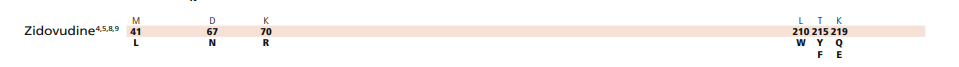


For Stavudine, we will examine seven positions: 41, 65, 67, 70, 210, 215, and 219. The wild-type residues at these positions are L, R, N, R, W, Y, and Q, respectively. Mutations at these sites such as  M41L, K65R, D67N, K70R, L210W, T215Y/F, and K219Q/E, several of which overlap with Zidovudine resistance mutations, are resistance mutations that reduce Stavudine susceptibility[1].

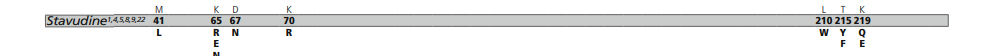

[1] Wensing, A. M., Calvez, V., Ceccherini-Silberstein, F., Charpentier, C., Günthard, H. F., Jacobsen, D. M., Paredes, R., Shafer, R. W., & Richman, D. D. (2025). 2025 update of the drug resistance mutations in HIV-1. International Antiviral Society–USA (IAS-USA). https://www.iasusa.org/wp-content/uploads/2025/03/33-2-mutations.pdf


Get the number of mutations and coverage

In [28]:
def get_mutations(pos):
    count_dict = {}
    pos_index = rt_start + pos -1 

    for row in rt_hits.itertuples():
        query_start = row.query_start
        query_end = row.query_end
        hit_id = row.hit_id
        hit_start = row.hit_start

        pos_index = rt_start + pos -1 

        if not (query_start <= pos_index and pos_index <= query_end):
            continue

        # do an offset to rt_start
        offset_start = pos_index - query_start
        
        # get the sequence from the rt_sequences_df
        sequence = rt_sequences_df[rt_sequences_df['read_id'] == hit_id]['sequence'].values[0]

        if 0 <= offset_start and offset_start < len(sequence):
            aa = sequence[offset_start]
            count_dict[aa] = count_dict.get(aa, 0) + 1
        else:
            continue

    print("Counts of amino acids at position")
    print("Position ",  pos, ":", ", ".join(f"{aa}: {count}" for aa, count in count_dict.items()))
    coverage = sum(count_dict.values())
    print("Coverage at position", pos, ":", coverage)
    
    return count_dict, coverage

In [29]:
key_positions = [41, 65, 67, 70, 210, 215, 219]
pos_mutations = {}

for i, pos in enumerate(key_positions):
    mutations, coverage = get_mutations(pos)
    pos_mutations[pos] = {
        "mutations": mutations,
        "coverage": coverage
    }
    print("\n")

Counts of amino acids at position
Position  41 : M: 3927, K: 5, I: 7, T: 34, V: 15, L: 4, R: 2, X: 3, N: 3, G: 1, W: 1
Coverage at position 41 : 4002


Counts of amino acids at position
Position  65 : K: 7495, E: 34, W: 7, R: 32, T: 4, Q: 2, N: 6, A: 1, *: 1, X: 3, S: 1, H: 1
Coverage at position 65 : 7587


Counts of amino acids at position
Position  67 : D: 7584, G: 55, Y: 4, K: 8, T: 12, E: 16, R: 3, V: 2, N: 11, A: 5, H: 2, W: 2, X: 4
Coverage at position 67 : 7708


Counts of amino acids at position
Position  70 : K: 8183, E: 40, R: 45, D: 8, I: 4, Q: 6, T: 17, N: 14, *: 4, G: 1, L: 2
Coverage at position 70 : 8324


Counts of amino acids at position
Position  210 : L: 21891, M: 19, F: 33, V: 49, S: 81, W: 12, X: 17, *: 8, I: 5, R: 7, G: 2, K: 1, P: 2, D: 1, N: 1, Y: 1
Coverage at position 210 : 22130


Counts of amino acids at position
Position  215 : T: 19848, I: 18, A: 89, Y: 40, P: 49, N: 27, H: 7, S: 30, F: 3, K: 2, X: 4
Coverage at position 215 : 20117


Counts of amino acid

Similar to the local alignment results, the pHMM alignments show the highest coverage for the wild-type residues at all examined positions. We will now examine the mutations in greater detail in the figure below.

Mutation table

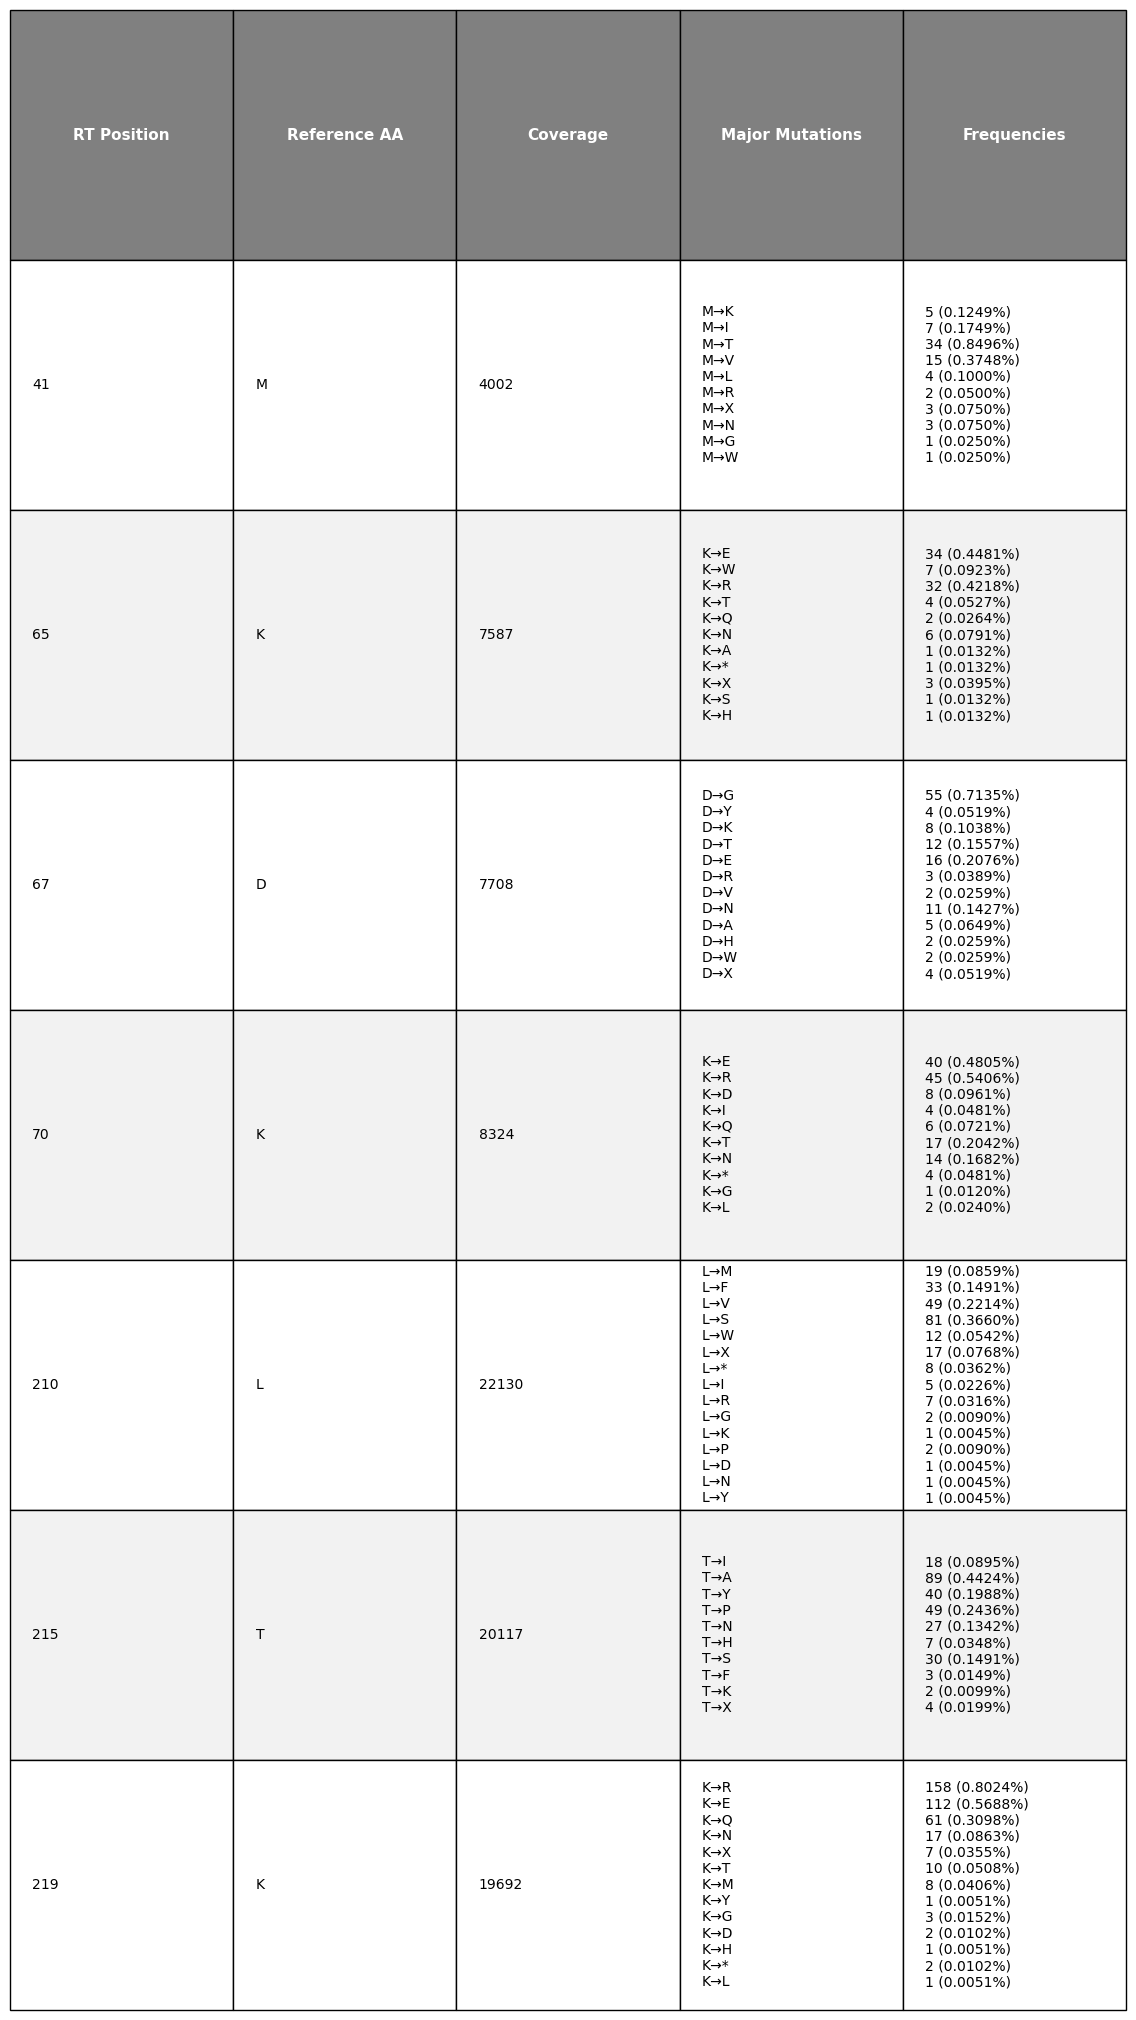

In [32]:
# Get reference AA (most common)
def get_reference_aa(muts):
    return max(muts.items(), key=lambda x: x[1])[0]

# Build rows
rows = []
for i, (pos, info) in enumerate(pos_mutations.items()):
    muts = info['mutations']
    cov = info['coverage']
    ref = get_reference_aa(muts)

    mut_list = []
    freq_list = []

    for aa, count in muts.items():
        if aa == ref:
            continue
        mut_list.append(f"{ref}→{aa}")
        freq_list.append(f"{count} ({count / cov * 100:.4f}%)")

    rows.append([
        str(pos),
        ref,
        str(cov),
        "\n".join(mut_list),
        "\n".join(freq_list)
    ])

# Calculate figure height
fig_height = len(rows) * 0.9

# Plot table
fig, ax = plt.subplots(figsize=(12, fig_height))
ax.axis('off')

table = ax.table(
    cellText=rows,
    colLabels=["RT Position", "Reference AA", "Coverage", "Major Mutations", "Frequencies"],
    cellLoc='left',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 15)  # Wider columns, taller rows

# Style header and alternate rows
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:
        cell.set_fontsize(11)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor("#808080")  # Green header
    elif row % 2 == 0:
        cell.set_facecolor("#f2f2f2")  # Light gray for even rows

# Optional: save as image
plt.savefig("mutation_table.png", bbox_inches="tight", dpi=300)

# plt.tight_layout()
plt.show()

Similar to the local alignment results, across the examined RT positions associated with Zidovudine and Stavudine resistance, drug resistance–associated mutations were detected within the patient sequence reads, including M41L, K65R, D67N, K70R, L210W, T215Y, K219E, and K219Q as reported by [1]. 

Zidovudine (AZT) and Stavudine (d4T) are thymidine analog nucleoside reverse transcriptase inhibitors (NRTIs) that, once converted to their active triphosphate forms, are incorporated into HIV DNA and cause chain termination by lacking the 3′-OH group needed for extension [2]. Resistance to these drugs arises through thymidine-analog mutations (TAMs), which enhance primer unblocking, the removal of a chain-terminating NRTI from viral DNA, and occur in two patterns: Type 1 (M41L, L210W, T215Y) and Type 2 (D67N, K70R, T215F, K219Q/E) [3].

**For Zidovudine, the relevant TAM-1 mutations (M41L, L210W, T215Y) and TAM-2 mutations (D67N, K70R, K219Q/E) were all found in our alignments. For Stavudine, the same TAM-associated changes are present, along with K65R, a non-TAM NRTI mutation observed at position 65. Although these resistance mutations are detected, their coverage is relatively low, with frequencies ranging from 0.1982% (T215Y) to 0.5668% (K219E) as shown in the figure**.

The following changes were observed in comparison the local alignment:
- K65R frequency decreased from 0.4335% to 0.4218%.
- D67N frequency increased slightly from 0.1424% to 0.1427%.
- K70R frequency decreased from 0.5488% to 0.5406%.
- T215Y frequency increased significantly from 0.0149% to 0.1982%.
- M41L, L210W, and K219E frequencies remained the same between the two.

The changes are quite small and insignificant. The results between local alignment and pHMM-based alignment are similar.

[1] Wensing, A. M., Calvez, V., Ceccherini-Silberstein, F., Charpentier, C., Günthard, H. F., Jacobsen, D. M., Paredes, R., Shafer, R. W., & Richman, D. D. (2025). 2025 update of the drug resistance mutations in HIV-1. International Antiviral Society–USA (IAS-USA). https://www.iasusa.org/wp-content/uploads/2025/03/33-2-mutations.pdf

[2] Patel PH, Zulfiqar H. Reverse Transcriptase Inhibitors. [Updated 2023 Jun 25]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2025 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK551504/

[3] HIV Drug Resistance Database. (2025, January 5). nrti Resistance Notes. Stanford University. Retrieved August 12, 2025, from https://hivdb.stanford.edu/dr-summary/resistance-notes/nrti/#k65r
